# This notebook superseded by cookie monster parallelization

In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import StationaryGaussianProcess

from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as np
import yaml
from led_array.tf_util import prepare_test_dataset
import tensorflow.keras as tfk

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-12-14 12:26:32.086014: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Opening BSCCM
Opened BSCCM


In [4]:
len(bsccm.get_indices()) * 29

11975289

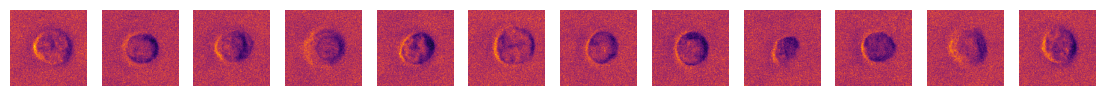

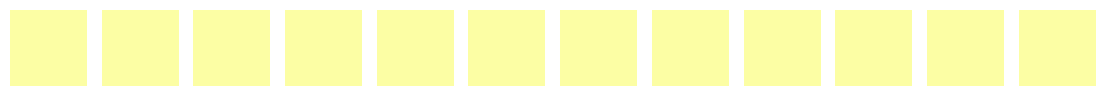

In [8]:


for config_path in \
    ['/home/hpinkard_waller/GitRepos/EncodingInformation/led_array/phenotyping_experiments/config_files/training/Synthetic_Noise_v2_DPC_Right_50_photons_replicate_0.yaml',
    '/home/hpinkard_waller/GitRepos/EncodingInformation/led_array/phenotyping_experiments/config_files/training/Synthetic_Noise_v2_DPC_Right_300_photons_replicate_0.yaml']:


    # safe load yaml
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)

    markers, image_target_generator, dataset_size, display_range, indices = get_bsccm_image_marker_generator(bsccm, **config['data'])
    test_dataset, test_dataset_size = prepare_test_dataset(config['hyperparameters']['test_fraction'], image_target_generator, dataset_size)
        
    i = 0
    images = []
    for image, target in test_dataset:
        images.append(image.numpy())
        if i > 10:
            break
        i += 1

    # plot all images
    fig, axs = plt.subplots(1, len(images), figsize=(14, 14))
    for i, image in enumerate(images):
        axs[i].imshow(image, cmap='inferno')
        axs[i].axis('off')



In [2]:
def get_marker_index(target_row):
    return np.flatnonzero(np.logical_not(np.isnan(target_row)))[0]

#compute negative log_likelihood over test set
def compute_nlls(model, test_dataset, max_num, markers):
    negative_log_likelihoods = []
    marker_indices = []
    for i, (image, target) in tqdm(enumerate(test_dataset), total=max_num):
        if max_num is not None and i > max_num:
            break
        marker_index = get_marker_index(target)
        marker_indices.append(marker_index)
        marker = markers[marker_index]
        mixture = model(image[None])[marker]
        nll = -mixture.log_prob(target[marker_index]).numpy() 
        negative_log_likelihoods.append(nll)
    return np.array(negative_log_likelihoods), np.array(marker_indices)


def estimate_mi(model_name, config, patch_size):
    saving_name = f'{model_name}_{patch_size}patch_mi_estimates'

        # check if already cached
    if os.path.exists(f'.cached/{saving_name}.npz'):
        print(f'Loading cached results for {model_name} MI estimates')
        return np.load(f'.cached/{saving_name}.npz')

    median_filter = config['data']['synthetic_noise']['median_filter']

    markers, image_target_generator, dataset_size, display_range, indices = get_bsccm_image_marker_generator(bsccm, **config['data'])
    images = load_bsccm_images(bsccm, indices=indices[:dataset_size], channel=config['data']['channels'][0], 
                convert_units_to_photons=True, edge_crop=config['data']['synthetic_noise']['edge_crop'],
                median_filter=median_filter)

    mean_photons_per_pixel = np.mean(images)
    rescale_fraction = config['data']['synthetic_noise']['photons_per_pixel'] / mean_photons_per_pixel
    if rescale_fraction > 1:
        raise Exception('Rescale fraction must be less than 1')

    patches = extract_patches(images, patch_size=patch_size, num_patches=int(dataset_size * 2))

    if median_filter:
        # assume noiseless
        noisy_patches = add_noise(patches * rescale_fraction)
    else:
        noisy_patches = add_shot_noise_to_experimenal_data(patches, rescale_fraction)
    
    mi_pixel_cnn = estimate_mutual_information(noisy_patches, clean_images=patches if median_filter else None, 
                    entropy_model='pixel_cnn', verbose=True)
    mi_gp = estimate_mutual_information(noisy_patches, clean_images=patches if median_filter else None,
                     entropy_model='gaussian', verbose=True)

    # save the cached results (both nlls and marker indices in a single file)
    np.savez(f'.cached/{saving_name}', mi_pixel_cnn=mi_pixel_cnn, mi_gp=mi_gp)
    return np.load(f'.cached/{saving_name}.npz')
    

def test_set_phenotyping_nll(model_name, config):
    saving_name = f'{model_name}_phenotyping_nll'

    # check if already cached
    if os.path.exists(f'.cached/{saving_name}.npz'):
        print(f'Loading cached results for {model_name} phenotyping nlls')
        return np.load(f'.cached/{saving_name}.npz')
    
    markers, image_target_generator, dataset_size, display_range, indices = get_bsccm_image_marker_generator(bsccm, **config['data'])
    test_dataset, test_dataset_size = prepare_test_dataset(config['hyperparameters']['test_fraction'], image_target_generator, dataset_size)
    
    model = tfk.models.load_model(config['saving_dir'] + model_name + os.sep + 'model/saved_model.h5', compile=False)

    nlls, marker_indices = compute_nlls(model, test_dataset, max_num=test_dataset_size, markers=markers)

    # save the cached results (both nlls and marker indices in a single file)
    np.savez(f'.cached/{saving_name}', nlls=nlls, marker_indices=marker_indices)
    return np.load(f'.cached/{saving_name}.npz')
    

## Compute and cache protein prediction performance

In [3]:
patch_size = 25

config_dir = '/home/hpinkard_waller/GitRepos/EncodingInformation/led_array/phenotyping_experiments/config_files/complete/'
# config_name = 'Synthetic_Noise_Brightfield_300_photons_replicate_1.yaml'
config_prefix = 'Synthetic_Noise_v1'

# make a cached_results directory if it doesn't exist
if not os.path.exists('.cached'):
    os.makedirs('.cached')

results = {}
files = os.listdir(config_dir)
for i, file in enumerate(files):
    print(f'file {i} of {len(files)}')
    if not file.startswith(config_prefix):
        continue # TODO remove this once subfolders

    model_name = file.split('.')[0]

    with open(config_dir + file, 'r') as f:
        config = yaml.safe_load(f)

    mi = estimate_mi(model_name, config,  patch_size)
    results = {**results, **mi}

    phenotyping_nll = test_set_phenotyping_nll(model_name, config)
    results = {**results, **phenotyping_nll}


file 0 of 24
Loading cached results for Synthetic_Noise_DPC_Right_50_photons_replicate_0 MI estimates
Loading cached results for Synthetic_Noise_DPC_Right_50_photons_replicate_0 phenotyping nlls
file 1 of 24
Loading cached results for Synthetic_Noise_LED119_100_photons_replicate_0 MI estimates
Loading cached results for Synthetic_Noise_LED119_100_photons_replicate_0 phenotyping nlls
file 2 of 24
Loading cached results for Synthetic_Noise_LED119_200_photons_replicate_1 MI estimates
Loading cached results for Synthetic_Noise_LED119_200_photons_replicate_1 phenotyping nlls
file 3 of 24
Loading cached results for Synthetic_Noise_Brightfield_300_photons_replicate_0 MI estimates
Loading cached results for Synthetic_Noise_Brightfield_300_photons_replicate_0 phenotyping nlls
file 4 of 24
Loading cached results for Synthetic_Noise_LED119_100_photons_replicate_1 MI estimates
Loading cached results for Synthetic_Noise_LED119_100_photons_replicate_1 phenotyping nlls
file 5 of 24
Loading cached res

Exception ignored in: <function _xla_gc_callback at 0x7f7840a4b7f0>
Traceback (most recent call last):
  File "/home/hpinkard_waller/mambaforge/envs/encoding_info/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 101, in _xla_gc_callback
    def _xla_gc_callback(*args):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1457, in _pydevd_bundle.pydevd_cython.SafeCallWrapper.__call__
  File "_pydevd_bundle/pydevd_cython.pyx", line 1758, in _pydevd_bundle.pydevd_cython.ThreadTracer.__call__
  File "/home/hpinkard_waller/mambaforge/envs/encoding_info/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_is_thread_alive.py", line 9, in is_thread_alive
    def is_thread_alive(t):
KeyboardInterrupt: 


Exception: Rescale fraction must be less than 1

# Testing new bug

In [1]:
"""
Script that trains a single model based on the info in a provided config file
"""

# this only works on startup!
from jax import config
import yaml
config.update("jax_enable_x64", True)



print("~~~~~~~~~~~~~running train script~~~~~~~~~~~~~~")
# from cookie_monster_backend_lib import train_script_setup, train_script_complete
# config_file_path, saving_dir, config, hyperparameters, already_elapsed_time, \
#     tensorboard_dir, logging_dir, model_dir, resume_backup_dir  = train_script_setup()

saving_dir = '/home/hpinkard_waller/models/Synthetic_Noise_v7/Analysis_Synthetic_Noise_v7_DPC_Right_100photons_replicate_0/'
model_dir = '/home/hpinkard_waller/models/Synthetic_Noise_v7/Analysis_Synthetic_Noise_v7_DPC_Right_100photons_replicate_0/model/'
config_file_path = '/home/hpinkard_waller/GitRepos/EncodingInformation/led_array/phenotyping_experiments/config_files/training/Analysis_Synthetic_Noise_v7_LED119_200photons_replicate_0.yaml'

# safe load yaml
with open(config_file_path, 'r') as f:
    config = yaml.safe_load(f)

#######################################################
### Enter your training code here #####################

# replace 'Analysis_' with ''
model_dir = model_dir.replace('Analysis_', '')



from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import StationaryGaussianProcess

from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as np
import yaml
from led_array.tf_util import prepare_test_dataset
import tensorflow.keras as tfk


def get_marker_index(target_row):
    return np.flatnonzero(np.logical_not(np.isnan(target_row)))[0]

#compute negative log_likelihood over test set
def compute_nlls(model, test_dataset, max_num, markers):
    negative_log_likelihoods = []
    marker_indices = []
    for i, (image, target) in tqdm(enumerate(test_dataset), total=max_num):
        if max_num is not None and i > max_num:
            break
        marker_index = get_marker_index(target)
        marker_indices.append(marker_index)
        marker = markers[marker_index]
        mixture = model(image[None])[marker]
        nll = -mixture.log_prob(target[marker_index]).numpy() 
        negative_log_likelihoods.append(nll)
    return np.array(negative_log_likelihoods), np.array(marker_indices)


def estimate_mi(model_name, config, patch_size, num_images=5000, num_patches=10000):
    saving_name = f'{model_name}_{patch_size}patch_mi_estimates'

        # check if already cached
    if os.path.exists(f'{saving_dir}/analysis/{saving_name}.npz'):
        print(f'Loading cached results for {model_name} MI estimates')
        return np.load(f'{saving_dir}/analysis/{saving_name}.npz')

    median_filter = config['data']['synthetic_noise']['median_filter']

    markers, image_target_generator, dataset_size, display_range, indices = get_bsccm_image_marker_generator(bsccm, **config['data'])
    images = load_bsccm_images(bsccm, indices=indices[:num_images], channel=config['data']['channels'][0], 
                convert_units_to_photons=True, edge_crop=config['data']['synthetic_noise']['edge_crop'],
                median_filter=median_filter)

    mean_photons_per_pixel = np.mean(images)
    rescale_fraction = config['data']['synthetic_noise']['photons_per_pixel'] / mean_photons_per_pixel
    if rescale_fraction > 1:
        raise Exception('Rescale fraction must be less than 1')

    patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)

    if median_filter:
        # assume noiseless
        noisy_patches = add_noise(patches * rescale_fraction)
    else:
        noisy_patches = add_shot_noise_to_experimenal_data(patches, rescale_fraction)
    clean_patches = patches * rescale_fraction
    
    # mi_pixel_cnn = estimate_mutual_information(noisy_patches, clean_images=clean_patches if median_filter else None, 
    #                 entropy_model='pixel_cnn', verbose=True)
    mi_gp = estimate_mutual_information(noisy_patches, clean_images=clean_patches if median_filter else None,
                     entropy_model='gaussian', verbose=True)

    # save the cached results (both nlls and marker indices in a single file)
    # create save directory if it doesn't exist
    if not os.path.exists(f'{saving_dir}/analysis'):
        os.makedirs(f'{saving_dir}/analysis')
    np.savez(f'{saving_dir}/analysis/{saving_name}', mi_pixel_cnn=mi_pixel_cnn, mi_gp=mi_gp)
    return np.load(f'{saving_dir}/analysis/{saving_name}.npz')
    

def test_set_phenotyping_nll(model_name, config):
    saving_name = f'{model_name}_phenotyping_nll'

    # check if already cached
    if os.path.exists(f'{saving_dir}/analysis/{saving_name}.npz'):
        print(f'Loading cached results for {model_name} phenotyping nlls')
        return np.load(f'{saving_dir}/analysis/{saving_name}.npz')
    
    markers, image_target_generator, dataset_size, display_range, indices = get_bsccm_image_marker_generator(bsccm, **config['data'])
    test_dataset, test_dataset_size = prepare_test_dataset(config['hyperparameters']['test_fraction'], image_target_generator, dataset_size)
    
    model = tfk.models.load_model(model_dir + '/saved_model.h5', compile=False)

    nlls, marker_indices = compute_nlls(model, test_dataset, max_num=test_dataset_size, markers=markers)

    # save the cached results (both nlls and marker indices in a single file)
    # create save directory if it doesn't exist
    if not os.path.exists(f'{saving_dir}/analysis'):
        os.makedirs('f{saving_dir}/analysis')
    np.savez(f'{saving_dir}/analysis/{saving_name}', nlls=nlls, marker_indices=marker_indices)
    return np.load(f'{saving_dir}/analysis/{saving_name}.npz')
    



bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')
# remove the .yaml and take the file name
model_name = config_file_path.split('/')[-1].split('.')[0]
# remove leading 'Analysis_' from model name
model_name = model_name.split('Analysis_')[-1]
patch_size = config['patch_size']

estimate_mi(model_name, config, patch_size)
test_set_phenotyping_nll(model_name, config)




#######################################################
##### Training complete file flag for scheduler #######
#######################################################
# train_script_complete(saving_dir)

~~~~~~~~~~~~~running train script~~~~~~~~~~~~~~


2023-12-13 10:44:17.989568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Opening BSCCM
Opened BSCCM


Exception: Rescale fraction must be less than 1